# **6. ML - Regression**

In [235]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Importar modelos
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Guardado del modelo
import joblib

In [211]:
# Cargar el archivo CSV
df = pd.read_csv('../data/processed/campana_marketing.csv', parse_dates=['Dt_Customer'])

# Convertir la columna 'Income' de float64 a int64
df['Income'] = df['Income'].astype('int64')

## Selección de variables X e Y
Como vimos al final del [**EDA**](04_explore_data.ipynb), introdujimos la posibilidad de explicar el nivel de consumo de un cliente a través de sus datos personales.

El objetivo será predecir el consumo determinado en el negocio de un posible cliente, a partir de sus datos personales: Predecir la cifra de `Spent` gracias a sus `personal_feature`

In [212]:
# Lista de características personales a evaluar
personal_features = ['Education', 'Marital_Status', 'Income', 
                     'Kidhome', 'Teenhome', 'Recency', 'Complain', 'Seniority', 
                     'Child_Home', 'Age']

# Calcular las correlaciones de Pearson con 'Spent'
correlations = df[personal_features + ['Spent']].corr()['Spent'].drop('Spent')

# Ordenar de mayor a menor en valor absoluto
ranking = correlations.abs().sort_values(ascending=False)

# Mostrar el ranking de correlaciones
print("Ranking de mejores correlaciones con 'Spent':")
print(ranking)

Ranking de mejores correlaciones con 'Spent':
Income            0.792362
Kidhome           0.558005
Child_Home        0.502355
Seniority         0.159123
Teenhome          0.137258
Age               0.114826
Education         0.110246
Complain          0.037386
Recency           0.019536
Marital_Status    0.018573
Name: Spent, dtype: float64


Determinamos que las variables con una correlación entre 0.1 y -0.1 quedarán excluidas de nuestro entrenamiento, ya que se encuentran entorno al 0 y parecen que no afectan a la variable objetivo y así aligeramos el proceso de entrenamiento.

In [213]:
# Seleccionar características con correlación absoluta mayor a 0.2
features = ranking[ranking > 0.1].index.tolist()

# Mostrar las características seleccionadas
print("Características seleccionadas:", features)

Características seleccionadas: ['Income', 'Kidhome', 'Child_Home', 'Seniority', 'Teenhome', 'Age', 'Education']


Definimos las variables

In [214]:
X = df[features]
y = df['Spent']

## División de datos
Cogeremos el 20% para test y el 80% para training

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Label Encoding o One-Hot Encoding para `Education`?
En [**Feature Engineering**](03_feature_engineering.ipynb), ya pasamos las categorías de texto a un **Label Encoding**, que está bien para modelos como árboles de decisión, random forest y XGBoost.

Sin embargo, para modelos lineales (Regresión Lineal, Elastic Net, SVM) y redes neuronales, **One-Hot Encoding** puede funcionar mejor.
### ¿Cómo manejar ambas versiones en paralelo?
Creamos dos versiones de X_train y X_test:
1. `X_train_tree` y `X_test_tree` → Usan Label Encoding (para Árboles, RF y XGBoost).
2. `X_train_linear` y `X_test_linear` → Usan One-Hot Encoding (para Modelos Lineales y NN).

In [216]:
# Version Label Encoding (para Árboles, RF, XGBoost)
X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

# Version One-Hot Encoding (para Regresión, Elastic Net, SVM, Redes Neuronales)
X_train_linear = X_train.copy()
X_test_linear = X_test.copy()

# Aplicar One-Hot Encoding SOLO en X_train_linear y X_test_linear
# Convertir a string
X_train_linear['Education'] = X_train_linear['Education'].astype(str)
X_test_linear['Education'] = X_test_linear['Education'].astype(str)
# Aplicar One-Hot Encoding
X_train_linear = pd.get_dummies(X_train_linear, columns=['Education'], drop_first=True)
X_test_linear = pd.get_dummies(X_test_linear, columns=['Education'], drop_first=True)

## Revisar y Manejar Valores Atípicos en `Income'
Como vimos en [**Data Cleaning**](02_data_cleaning.ipynb), `Income` tiene valores altos, y si hay outliers extremos, pueden afectar modelos sensibles como **Regresión Lineal, Elastic Net y SVM**.

Para suavizar valores extremos en `Income`, se aplicará una transformación logarítmica que reduce la magnitud de los valores altos.

In [217]:
# Crear copias para los modelos lineales (Regresión Lineal, Elastic Net, SVM)
X_train_linear_log = X_train_linear.copy()
X_test_linear_log = X_test_linear.copy()

# Aplicar transformación logarítmica solo a 'Income'
X_train_linear_log['Income'] = np.log1p(X_train_linear_log['Income'])  # log1p evita log(0)
X_test_linear_log['Income'] = np.log1p(X_test_linear_log['Income'])

## Escalar Variables Numéricas: `Income`, `Seniority` y `Age`
Algunos modelos (KNN, Regresión Lineal, Elastic Net, SVM, Redes Neuronales) necesitan que todas las variables estén en una escala similar para funcionar bien.
### Solución: Estándar o MinMaxScaler?
1. **StandardScaler** (media 0, varianza 1) → Mejor para modelos que asumen normalidad (Regresión Lineal, SVM, Elastic Net).
2. **MinMaxScaler** (valores entre 0 y 1) → Funciona bien para Redes Neuronales y KNN.

Se crean por lo tanto, 2 versiones más de datos:

In [218]:
# Copiamos los conjuntos originales
X_train_linear_std = X_train_linear_log.copy()
X_test_linear_std = X_test_linear_log.copy()

X_train_nn_mm = X_train_linear.copy()
X_test_nn_mm = X_test_linear.copy()

# Seleccionar solo variables numéricas (evitar aplicar escalado a dummies de One-Hot Encoding)
num_features = ['Income', 'Kidhome', 'Child_Home', 'Seniority', 'Teenhome', 'Age']

# Aplicar StandardScaler (Regresión Lineal, Elastic Net, SVM)
scaler_std = StandardScaler()
X_train_linear_std[num_features] = scaler_std.fit_transform(X_train_linear_std[num_features])
X_test_linear_std[num_features] = scaler_std.transform(X_test_linear_std[num_features])

# Aplicar MinMaxScaler (Redes Neuronales, KNN)
scaler_mm = MinMaxScaler()
X_train_nn_mm[num_features] = scaler_mm.fit_transform(X_train_nn_mm[num_features])
X_test_nn_mm[num_features] = scaler_mm.transform(X_test_nn_mm[num_features])

### Resumen final de versiones de datos

| **Versiones de X**               | **Codificación `Education`**        | **Transformación**        | **Escalado en Var.Numéricas**         | **Modelos a aplicar** |
|--------------------------------|------------------------|--------------------------|----------------------|--------------------------|
| `X_train_tree`, `X_test_tree`  | Label Encoding         | Sin transformación       | Sin escalar         | Árboles, RF, XGBoost     |
| `X_train_linear_std`, `X_test_linear_std`  | One-Hot Encoding | Log en `Income`          | StandardScaler      | Regresión Lineal, Elastic Net, SVM |
| `X_train_nn_mm`, `X_test_nn_mm` | One-Hot Encoding       | Sin transformación       | MinMaxScaler        | Redes Neuronales, KNN    |



## Selección de modelos

Se hará la **paralelización** con `n_jobs=-1` en los modelos que lo soporten para usar todos los núcleos disponibles y acelerar el entrenamiento de estos modelos.

In [219]:
# Definir los modelos con sus datos correspondientes
models = {
    'Linear Regression': (LinearRegression(n_jobs=-1), X_train_linear_std, y_train),
    'Ridge': (Ridge(), X_train_linear_std, y_train),
    'Lasso': (Lasso(), X_train_linear_std, y_train),
    'Elastic Net': (ElasticNet(), X_train_linear_std, y_train),
    'KNN': (KNeighborsRegressor(n_jobs=-1), X_train_nn_mm, y_train),
    'Decision Tree': (DecisionTreeRegressor(), X_train_tree, y_train),
    'SVM': (SVR(), X_train_linear_std, y_train),
    'Random Forest': (RandomForestRegressor(n_jobs=-1), X_train_tree, y_train),
    'XGBoost': (xgb.XGBRegressor(n_jobs=-1, tree_method="hist", device="cuda:0", predictor="gpu_predictor"), X_train_tree, y_train),
    'Neural Network': (MLPRegressor(solver='adam', early_stopping=True, random_state=42, verbose=False, batch_size=64), X_train_nn_mm, y_train)
}

## Hiperparámetros para la Búsqueda Exhaustiva con GridSearchCV

### En la busqueda del balance entre rendimiento y prevención de overfitting
- **Regularización**: Se han incluido `alpha` (L2) y `l1_ratio` (Elastic Net) para evitar sobreajuste en modelos lineales.
- **Reducción de complejidad**: Se han restringido los valores de `max_depth`, `min_samples_split` y `min_samples_leaf` en árboles y Random Forest.
- **Uso de menor tasa de aprendizaje**: XGBoost usa 0.05, 0.1, 0.2 en `learning_rate` para evitar aprendizaje demasiado rápido.
- **Arquitecturas compactas en Redes Neuronales**: Se han seleccionado arquitecturas moderadas con 1 o 2 capas para mejorar generalización.

In [220]:
# Hiperparámetros para GridSearchCV en modelos de regresión
param_grid = {
    'Linear Regression': {},  # No tiene hiperparámetros ajustables

    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10, 100],  # Fuerza de regularización L2
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    
    'Lasso': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],  # Fuerza de regularización L1
        'selection': ['cyclic', 'random']  # Método de selección de features
    },

    'Elastic Net': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1],  # Regularización combinada L1 y L2
        'l1_ratio': [0.1, 0.5, 0.9]  # Proporción entre L1 y L2 (0=L2, 1=L1)
    },

    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],  # Vecinos considerados
        'weights': ['uniform', 'distance'],  # Ponderación por distancia
        'p': [1, 2]  # 1: Manhattan, 2: Euclidiana
    },

    'Decision Tree': {
        'max_depth': [3, 5, 10, 20, None],  # Profundidad del árbol
        'min_samples_split': [2, 5, 10],  # Min. muestras para dividir nodo
        'min_samples_leaf': [1, 2, 5]  # Min. muestras en nodos hojas
    },

    'SVM': {
        'C': [0.1, 1, 10, 100],  # Regularización
        'gamma': ['scale', 'auto', 0.01, 0.1],  # Influencia de ejemplos de entrenamiento
        'kernel': ['linear', 'rbf']  # Tipos de kernel
    },

    'Random Forest': {
        'n_estimators': [50, 100, 200, 500],  # Número de árboles
        'max_depth': [3, 5, 10, None],  # Profundidad máxima
        'min_samples_split': [2, 5, 10],  # Muestras mínimas por nodo
        'min_samples_leaf': [1, 2, 5]  # Muestras mínimas en hojas
    },

    'XGBoost': {
        'n_estimators': [100, 300, 500],  # Número de árboles de boosting (iteraciones)
        'learning_rate': [0.05, 0.1, 0.2],  # Tasa de aprendizaje (eta)
        'max_depth': [3, 5, 7],  # Profundidad máxima de árboles
        'subsample': [0.8, 0.9, 1.0],  # Fracción de datos para cada árbol
        'colsample_bytree': [0.8, 1.0],  # Fracción de features por árbol
        'reg_lambda': [1, 10],  # Regularización L2 (lambda)
        'reg_alpha': [0, 1]  # Regularización L1 (alpha)
    },

    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,)],  # Solo arquitecturas simples
        'activation': ['relu'],  # Funciones de activación
        'alpha': [0.001, 0.01],  # Término de regularización L2
        'learning_rate_init': [0.001],  # Tasa de aprendizaje inicial
        'max_iter': [500],   # Máximo de iteraciones
        'tol': [1e-3],             # Tolerancia para early stopping
        'beta_1': [0.9],           # Parámetros de Adam
        'beta_2': [0.999]
    }
}

## Entrenamiento y recogida de resultados
Para evitar **Overfitting**, mantenemos `early_stopping_rounds` en **XGBoost** con validación interna, pero como `GridSearchCV` no lo permite directamente, hay que dividir los datos de entrenamiento en un conjunto de entrenamiento reducido y un conjunto de validación dentro del bucle for. Usamos `train_test_split` para crear estos conjuntos antes de llamar a `GridSearchCV.fit()`.

Una **Cross-validation** más intensivo (`cv=10`) ayudará también a evitar **Overfitting**.

Intentamos que **XGBoost** entrene completamente en la GPU y paralelización (`n_jobs=-1`) en modelos compatibles para acelerar entrenamiento.

In [221]:
# Diccionario para almacenar resultados y mejores modelos
results = {}
best_models = {}

# Iterar sobre cada modelo
for model_name, (model, X_data, y_data) in models.items():
    print(f"\nEntrenando {model_name}...")
    
    # Configuración especial para XGBoost con GPU y early stopping
    if model_name == 'XGBoost':
        # Dividir datos para early stopping (90% train, 10% validation)
        X_train_part, X_val, y_train_part, y_val = train_test_split(
            X_data, y_data, test_size=0.1, random_state=42
        )
        
        # Configuración óptima para GPU
        gpu_params = {
            'tree_method': 'hist',
            'device': 'cuda:0',
            'predictor': 'gpu_predictor',
            'early_stopping_rounds': 10,
            'eval_metric': 'rmse',
            'verbosity': 0
        }
        model.set_params(**gpu_params)

        # GridSearchCV optimizado para GPU
        grid_search = GridSearchCV(
            estimator=model, param_grid=param_grid[model_name], 
            scoring='neg_root_mean_squared_error', cv=10, n_jobs=1, refit=True
        )

        # Entrenamiento con validación temprana
        grid_search.fit(X_train_part, y_train_part, eval_set=[(X_val, y_val)], verbose=False)

    else:
        # Configuración estándar para otros modelos
        grid_search = GridSearchCV(
            model, param_grid[model_name], 
            scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1
        )
        grid_search.fit(X_data, y_data)

    # Mejor modelo y parámetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Seleccionar conjunto de test adecuado según modelo
    if model_name in ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net', 'SVM']:
        X_test_final = X_test_linear_std
    elif model_name == 'KNN':
        X_test_final = X_test_nn_mm
    elif model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        X_test_final = X_test_tree
    elif model_name == 'Neural Network':
        X_test_final = X_test_nn_mm

    # Predicciones en test
    y_pred = best_model.predict(X_test_final)

    # Calcular métricas de regresión
    results[model_name] = {
        'R2 Score': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'Best Params': best_params
    }

    # Guardar mejor modelo
    best_models[model_name] = best_model

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results).T
numeric_cols = ['R2 Score', 'MAE', 'RMSE']
results_df[numeric_cols] = results_df[numeric_cols].astype(float).round(4)


Entrenando Linear Regression...

Entrenando Ridge...

Entrenando Lasso...

Entrenando Elastic Net...

Entrenando KNN...

Entrenando Decision Tree...

Entrenando SVM...

Entrenando Random Forest...

Entrenando XGBoost...

Entrenando Neural Network...


/home/kyke/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/marketing-ml-a6pcPZMr-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyke/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/marketing-ml-a6pcPZMr-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyke/.var/app/com.visualstudio.code/cache/pypoetry/virtualenvs/marketing-ml-a6pcPZMr-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kyke/.var/app/com.visualstudio.code/cache/pypo

## Evaluación y Análisis de los Resultados
### Resultados

In [222]:
print("\n🔹 Resultados de los modelos:")
print(results_df)

# Determinar el mejor modelo basado en diferentes métricas
best_metrics = {
    metric: results_df[metric].idxmin()  # Para RMSE y MAE (menor es mejor)
    for metric in ['MAE', 'RMSE']
}

best_metrics.update({
    metric: results_df[metric].idxmax()  # Para R² (mayor es mejor)
    for metric in ['R2 Score']
})

print("\n🔹 Mejores modelos por métrica:")
for metric, model in best_metrics.items():
    print(f"Mejor modelo basado en {metric}: {model} - {results_df.at[model, 'Best Params']}")


🔹 Resultados de los modelos:
                   R2 Score       MAE      RMSE  \
Linear Regression    0.6701  270.7115  349.6474   
Ridge                0.6711  270.4379  349.0921   
Lasso                0.6713  270.3232  349.0122   
Elastic Net          0.6715  270.3134  348.8984   
KNN                  0.7513  191.5830  303.5537   
Decision Tree        0.7945  193.1600  275.9111   
SVM                  0.7979  190.0391  273.6450   
Random Forest        0.8372  171.6779  245.5861   
XGBoost              0.8214  182.2796  257.2426   
Neural Network       0.6676  261.5139  350.9532   

                                                         Best Params  
Linear Regression                                                 {}  
Ridge                                 {'alpha': 10, 'solver': 'sag'}  
Lasso                            {'alpha': 1, 'selection': 'random'}  
Elastic Net                          {'alpha': 0.1, 'l1_ratio': 0.9}  
KNN                {'n_neighbors': 5, 'p': 1, 'weight

## Interpretación Detallada de Resultados

### 🔹 **Random Forest: El Modelo con Mejor Rendimiento Global**
- **R² Score**: 0.8372 (**Mejor entre todos los modelos**)  
- **MAE**: 171.68 (Error absoluto más bajo)  
- **RMSE**: 245.59 (**Menor error cuadrático medio**)  

*Conclusión*:  
Random Forest es el modelo más preciso en términos de predicción general. Se recomienda cuando se busca **minimizar el error absoluto y cuadrático medio**, asegurando una buena generalización.  

---

### 🔹 **XGBoost: Fuerte Alternativa con Buen Equilibrio**
- **R² Score**: 0.8214  
- **MAE**: 182.28  
- **RMSE**: 257.24  

*Ventajas*:  
- Modelo eficiente y optimizado para grandes volúmenes de datos  
- Puede beneficiarse de un ajuste más fino de hiperparámetros  
- Ligeramente menos preciso que Random Forest, pero con buen rendimiento  

*Recomendación*:  
Ideal para **situaciones con grandes volúmenes de datos o donde el entrenamiento rápido sea una prioridad.**  

---

### 🔹 **SVM y Decision Tree: Alternativas con Buen Rendimiento**

| Métrica   | SVM    | Decision Tree |
|-----------|--------|--------------|
| R² Score  | 0.7979 | 0.7945       |
| MAE       | 190.03 | 193.16       |
| RMSE      | 273.64 | 275.91       |

🔹 **SVM**: Ligeramente superior en todas las métricas, buena opción cuando se requiere estabilidad en la predicción.  
🔹 **Decision Tree**: Simplicidad y rapidez, pero con menor capacidad de generalización que Random Forest.  

 *Recomendación*:  
- **SVM** puede ser útil en casos donde los datos son bien estructurados y la complejidad del modelo debe mantenerse controlada.  
- **Decision Tree** es adecuado para interpretabilidad rápida, pero puede ser sensible al sobreajuste.  

---

### 🔹 **KNN: Buen Desempeño Relativo, pero Menos Robusto**
- **R² Score**: 0.7513  
- **MAE**: 191.58  
- **RMSE**: 303.55  

 *Conclusión*:  
KNN ofrece un rendimiento decente, pero es **menos eficiente que los modelos basados en árboles**. Puede ser útil en casos donde la proximidad entre puntos de datos es clave, pero **no es la mejor opción en términos de precisión global.**  

---

### 🔹 **Modelos Lineales: Simples pero Menos Precisos**

| Modelo          | R² Score | MAE    | RMSE    |
|----------------|---------|--------|--------|
| Linear Reg.    | 0.6701  | 270.71 | 349.65 |
| Ridge          | 0.6711  | 270.43 | 349.09 |
| Lasso          | 0.6713  | 270.32 | 349.01 |
| Elastic Net    | 0.6715  | 270.31 | 348.89 |

 *Conclusión*:  
Los modelos lineales son los menos efectivos en este problema, con **errores significativamente más altos** y **menor capacidad de captura de relaciones complejas**. Son útiles para interpretabilidad y eficiencia, pero no recomendados si se busca la mayor precisión posible.  

---

### 🔹 **Neural Network: Problemas de Generalización**
- **R² Score**: 0.6676 (Peor desempeño en comparación con otros modelos)  
- **MAE**: 261.51 (Error más alto que KNN, árboles y modelos lineales)  
- **RMSE**: 350.95  

 *Advertencia*:  
- Modelo no ha logrado converger correctamente.  
- Mayor error absoluto y cuadrático medio.  
- Probablemente requiere **más ajustes en la arquitectura** o **más datos para mejorar la estabilidad**.  

 *Posibles causas del mal rendimiento*:  
- Falta de optimización en los hiperparámetros.  
- Necesidad de una red más profunda o mejor regularización.  
- Insuficiente cantidad de datos de entrenamiento.  

 *Recomendación*:  
Evitar su uso en su estado actual, a menos que se realicen mejoras significativas en la arquitectura y el entrenamiento.  

---

## **Conclusión General**
1. **Random Forest** es el modelo con **mejor rendimiento general**, ideal si se busca **la mayor precisión posible**.  
2. **XGBoost** ofrece un equilibrio entre precisión y velocidad, siendo una excelente alternativa.  
3. **SVM y Decision Tree** son opciones sólidas, pero con menor rendimiento en comparación con Random Forest y XGBoost.  
4. **KNN y Modelos Lineales** no son las mejores opciones, pero pueden ser útiles en casos específicos.  
5. **Neural Network** no ha logrado un buen desempeño y necesita ajustes significativos.  

 **Si se busca el mejor modelo con la menor cantidad de errores, Random Forest es la mejor elección.** 


## Visualización de los Resultados

### Comparación Global de Modelos

<Figure size 1200x600 with 0 Axes>

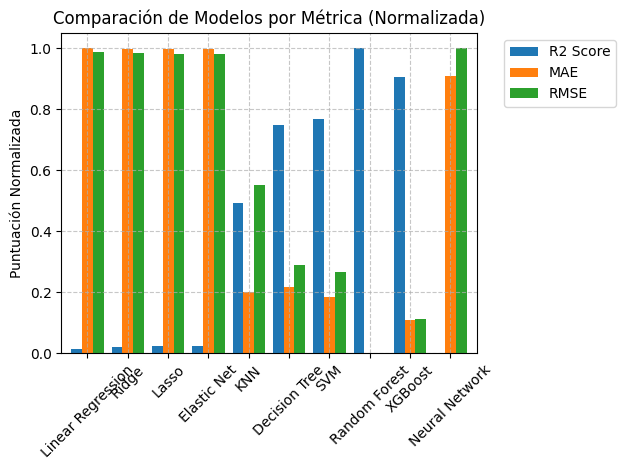

In [225]:
# Normalizar las métricas para que sean comparables
normalized_df = results_df.copy()
for metric in ['R2 Score', 'MAE', 'RMSE']:
    normalized_df[metric] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())

# Graficar
plt.figure(figsize=(12, 6))
normalized_df[['R2 Score', 'MAE', 'RMSE']].plot(kind='bar', width=0.8)
plt.title('Comparación de Modelos por Métrica (Normalizada)')
plt.ylabel('Puntuación Normalizada')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Para Random Forest:
- R² Score: Es el mejor, por lo que aparece con un valor de 1.
- MAE y RMSE: Son las más bajas en Random Forest (lo cual es bueno, porque minimizamos error). Al normalizarlas, sus valores se acercan a 0, y por eso no parecen.

### Gráfico de Predicción vs Real para el Mejor Modelo: Random Forest

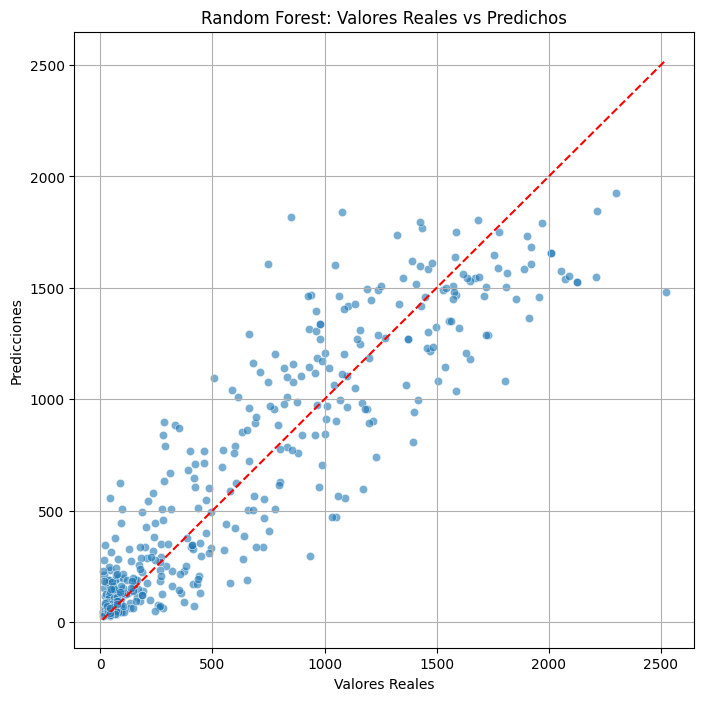

In [226]:
best_model = best_models['Random Forest']
y_pred = best_model.predict(X_test_tree)

plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Valores Reales vs Predichos')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()

El gráfico muestra la comparación entre los valores reales y las predicciones del modelo Random Forest, donde la mayoría de los puntos siguen la línea roja de referencia (y=x), indicando un **buen ajuste**, aunque con cierta **dispersión en valores altos**.

### Gráfico de Residuales

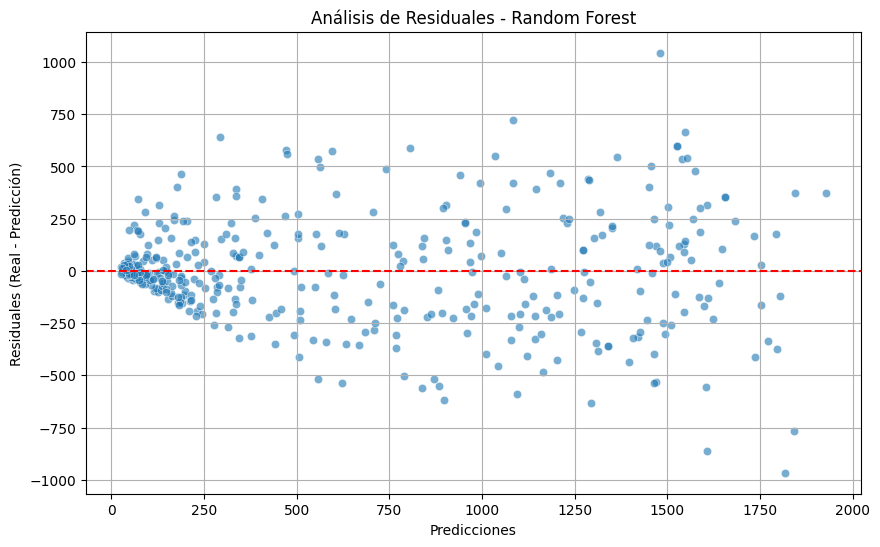

In [227]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Análisis de Residuales - Random Forest')
plt.xlabel('Predicciones')
plt.ylabel('Residuales (Real - Predicción)')
plt.grid(True)
plt.show()

El gráfico de residuales muestra una **dispersión relativamente homogénea** alrededor de la línea roja (y = 0), lo que sugiere que el modelo Random Forest no presenta un sesgo evidente, aunque hay **mayor variabilidad en predicciones altas**.

### Feature Importance

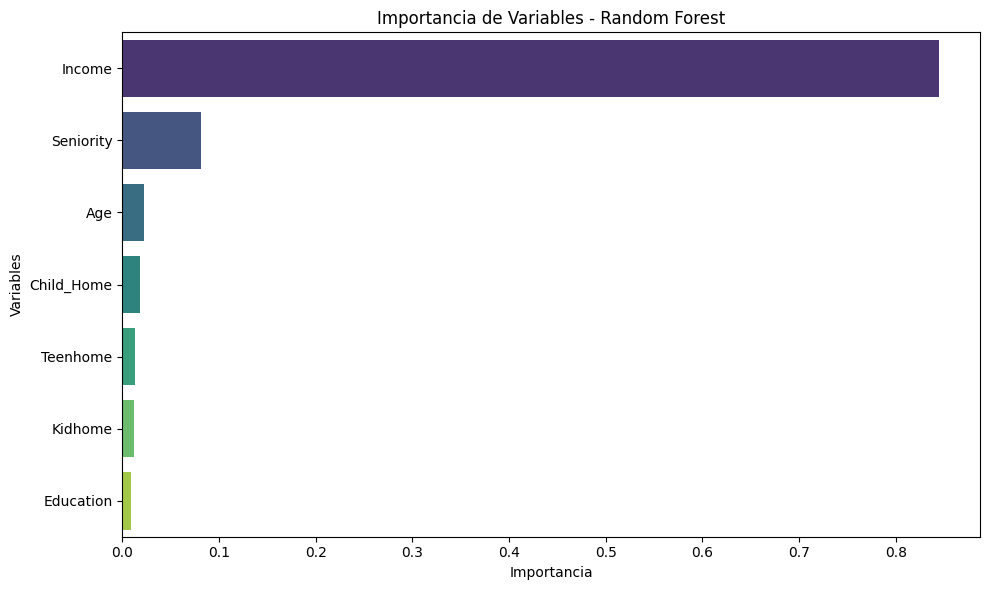

In [232]:
feature_importances = best_model.feature_importances_
features = X_train_tree.columns

# Crear DataFrame ordenado por importancia
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], hue=features, palette='viridis', legend=False)
plt.title('Importancia de Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

El gráfico muestra la importancia relativa de las variables en el modelo **Random Forest**, donde `Income` es la variable más influyente (con mayor peso) y `Education` la menos relevante, usando una escala de importancia de 0 a 0.8.

## Guardar modelo

In [237]:
joblib.dump((best_models['Random Forest']), '../models/regression/RandomForestRegressor.pkl')

['../models/regression/RandomForestRegressor.pkl']